# Gaussian Process on the Power Plant UCI dataset, using Inducing Points and all points

# Github

In [ ]:
from google.colab import drive # For github
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Project18/GPs
!git config --global user.email "alexander.sabelstrom.1040@student.uu.se"
!git config --global user.name "Sabelz"

Mounted at /content/drive
/content/drive/MyDrive/Project18/GPs


# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
!pip install gpytorch
import gpytorch
from sklearn.model_selection import train_test_split
import math
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import time
%matplotlib inline
%load_ext autoreload
%autoreload 2
%run ../datasets/powerPlant.ipynb # Run the PowerPlant notebook which is in the datasets folder(PowerPlant dataset)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 7.8 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Project18/datasets
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB
None

AT    False
V     False
AP    False
RH    False
PE    False
dtype: bool


# Training/Test data from powerPlant.ipynb

In [ ]:
# Use standardized target variables if wanted, some parts of code needs to be uncommented/changed

# Set a seed for reproducibility
np.random.seed(52)

powerPlant_data = df_PowerPlant # df_PowerPlant is defined in ../datasets/powerPlant.ipynb
x, y = powerPlant_data.iloc[:, :-1].to_numpy() , powerPlant_data.iloc[:, -1].to_numpy()  # The last column is output(net hourly electrical energy output (EP)  of the plant)

# Split into training and validation datasets
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.1)

# Standardize training input points
xTrain_mean = xTrain.mean(axis = 0) # mean for each feature
xTrain_std = xTrain.std(axis = 0) # std for each feature
xTrain_standardized = (xTrain-xTrain_mean) / xTrain_std # Standardize
# Standardize training output points
#yTrain_mean = yTrain.mean(axis = 0) # mean
#yTrain_std = yTrain.std(axis = 0) # std
#yTrain_standardized = (yTrain-yTrain_mean) / yTrain_std # Standardize
#yTrain_standardized_mean = yTrain_standardized.mean(axis = 0) # Mean after standardization

# Standardize test input points
xTest_mean = xTest.mean(axis = 0) # mean for each feature
xTest_std = xTest.std(axis = 0) # std for each feature
xTest_standardized = (xTest-xTest_mean) / xTest_std # Standardize
# Standardize test output points
#yTest_mean = yTest.mean(axis = 0) # mean
#yTest_std = yTest.std(axis = 0) # std
#yTest_standardized = (yTest-yTest_mean) / yTest_std # Standardize
#yTest_standardized_mean = yTest_standardized.mean(axis = 0) # Mean after standardization

# Convert them to tensors
xTrain_standardized = torch.from_numpy(xTrain_standardized).float()
#yTrain_standardized = torch.from_numpy(yTrain_standardized).float()

xTest_standardized = torch.from_numpy(xTest_standardized).float()
#yTest_standardized = torch.from_numpy(yTest_standardized).float()

yTrain = torch.from_numpy(yTrain).float()
yTest = torch.from_numpy(yTest).float()
print(xTrain_standardized.size(), yTrain.size, xTest_standardized.size(), yTest.size)

torch.Size([8611, 4]) <built-in method size of Tensor object at 0x7a923e096390> torch.Size([957, 4]) <built-in method size of Tensor object at 0x7a923e094d60>


# The GP model

In [ ]:
# Class for the GP model(Exact GP)
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, x, y, likelihood):
        super(GPModel, self).__init__(x, y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() # Decide which mean to use
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) # Decide which kernel to use
    # GP Posterior predictive distribution
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize the first model

In [ ]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
model = GPModel(xTrain_standardized, yTrain, likelihood) # Use training points and given likelihood
if torch.cuda.is_available():
    model = model.cuda()
    model.likelihood = likelihood.cuda()

# Training Function for plotting

In [ ]:
import os
def train_plotting(model, xTrain, yTrain, xTest, yTest): # Train the model on training data: xTrain, yTrain
  smoke_test = ('CI' in os.environ)
  training_iter = 2 if smoke_test else 30
  iterations_list = np.arange(1, training_iter+1, 1) # Create x values for plot
  train_loss_list = [] # Create list for training loss
  val_loss_list = [] # Create list for validation errors
  # Find optimal model hyperparameters
  model.train()
  model.likelihood.train()

  # Use the adam optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

  # "Loss" for GPs - the marginal log likelihood
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
  # Train without printing to ensure the training method is as fast as possible
  for i in range(training_iter):
      # Zero gradients from previous iteration
      optimizer.zero_grad()
      # Output from model
      output = model(xTrain)
      # Calc loss
      loss = -mll(output, yTrain)
      # Backprop gradients
      loss.backward()
      optimizer.step()

      train_loss_list.append(loss.item()) # Append training loss
     # Current validation loss
      model.eval()
      with torch.no_grad():
        output_val = model(xTest)
        loss_val = -mll(output_val, yTest)
        val_loss_list.append(loss_val.item())
      # Switch back to training mode
      model.train()

  return iterations_list, train_loss_list, val_loss_list # Used for plotting

# Train the Model

In [ ]:
iterations_list, train_loss_list, val_loss_list = train_plotting(model, xTrain_standardized, yTrain, xTest_standardized, yTest)

KeyboardInterrupt: ignored

#Plot Training/Validation loss for every iteration

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))  # Create a figure and a subplot

# Plot Training Loss
ax.plot(iterations_list, train_loss_list, label='Training loss', color="purple")

# Plot Validation Loss
ax.plot(iterations_list, val_loss_list, label='Validation loss', color="blue")

ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation loss per Iteration for Power Dataset')
ax.set_xlim(left = 0)
ax.legend()

plt.show()

#Training function

In [ ]:
import os
def train(model, xTrain, yTrain): # Train the model on training data: xTrain, yTrain

  smoke_test = ('CI' in os.environ)
  training_iter = 2 if smoke_test else 30


  # Find optimal model hyperparameters
  model.train()
  model.likelihood.train()

  # Use the adam optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

  # "Loss" for GPs - the marginal log likelihood
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
  # Train without printing to ensure the training method is as fast as possible
  for i in range(training_iter):
      # Zero gradients from previous iteration
      optimizer.zero_grad()
      # Output from model
      output = model(xTrain)
      # Calc loss and backprop gradients
      loss = -mll(output, yTrain)
      loss.backward()
      optimizer.step()

# The posterior mean, variance and Covariance Matrix

In [ ]:
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
  model.eval() # eval mode is for computing predictions through the model posterior
  f_preds = model(xTest_standardized) # returns the model posterior distribution p(f* | x*, X, y), for training data X, y
  f_mean = f_preds.mean # Predictive mean
  f_var = f_preds.variance # Predictive variance
  f_covar = f_preds.covariance_matrix # Covariance matrix
  print("Mean Dimension: ", f_mean.size())
  print()
  print("Variance Dimension: ", f_var.size())
  print()
  print("CovMatrix Dimension ", f_covar.size())

Mean Dimension:  torch.Size([957])

Variance Dimension:  torch.Size([957])

CovMatrix Dimension  torch.Size([957, 957])


# Predictive Distribution

In [ ]:
model.eval() # eval mode is for computing predictions through the model posterior.
model.likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
    observed_pred = model.likelihood(f_preds)# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value
    prediction_means = observed_pred.mean.numpy()

# Compute Root Mean Square Error (RMSE)

In [ ]:
#squared_error_standardized = (prediction_means -  yTest_standardized.numpy())**2 # Compute the squared error
squared_error = (prediction_means -  yTest.numpy())**2 # Compute the squared error
mean_SE = squared_error.mean() # Compute the mean squared error

root_MSE = math.sqrt(mean_SE) # Compute the square root of the mean squared error
print("RMSE: ", root_MSE)
#print("Normalized RMSE: ", root_MSE)
# To transform the RMSE back to the original scale after normalization,
# you can simply multiply the RMSE by the standard deviation of the original output data and add the mean
#print("RMSE: ", (root_MSE * yTest_std) + yTest_standardized_mean)

RMSE:  5.594946877071397


# Calculate RMSE with original scales

In [ ]:
#meanTensor = torch.tensor(prediction_means) # Convert to tensor
#predictions_original = ((meanTensor*yTest_std)+yTest_mean) # Transform to original scale

#squared_error = (predictions_original -  yTest)**2 # Compute the squared error

#mean_SE = squared_error.mean() # Compute the mean squared error
#root_MSE = math.sqrt(mean_SE) # Compute the square root of the mean squared error

#print("Normalized RMSE: ", root_MSE)

# Prediction Interval Coverage Probability (PICP)
# and
# Mean Prediction Interval Width (MPIW)

In [ ]:
import torch
from scipy.stats import norm

def compute_z_score(pred_interval: float) -> float:
    """
    Compute the z-score based on a given prediction interval.

    Parameters:
    - pred_interval (float): Prediction interval in the range (0, 100).

    Returns:
    float: The z-score corresponding to the given prediction interval.
    """
    # Convert pred_interval to a probability
    probability = pred_interval / 100

    # Compute z-score based on the probability
    z = norm.ppf((1 + probability) / 2)

    return z

def calculate_PIC_PIW(PIC:float, PIW:float, n:int, means:torch.Tensor, variances: torch.Tensor, y_true: torch.Tensor, pred_interval: float=95.0):
    """"
    Calculate Prediction Interval Coverage (PIC) and Prediction Interval Width (PIW) for a batch of predictions.

    Parameters:
    - PIC (float): Current Prediction Interval Coverage.
    - PIW (float): Current Prediction Interval Width.
    - n (int): Current total number of data points.
    - means (torch.Tensor): Tensor containing mean predictions.
    - variances (torch.Tensor): Tensor containing variances of predictions.
    - y_true (torch.Tensor): Tensor containing true values.
    - pred_interval (float, optional): Desired prediction interval (default is 90.0).

    Returns:
    Tuple of three values (PIC, PIW, n) representing the updated values after processing the current batch.

    This function calculates the Prediction Interval Coverage (PIC) and Prediction Interval Width (PIW) for a batch
    of predictions.

    The Prediction Interval (PI) is calculated as [mean - z * sqrt(variance), mean + z * sqrt(variance)], where z is
    determined based on the desired prediction interval.

    The function updates the input PIC, PIW, and n based on the performance of the model on the current batch.
    """
    z = compute_z_score(pred_interval)
    sigma = torch.sqrt(variances)
    # Update n by the batch size
    n += means.shape[0]
    # Calculate y_pred lower bound
    y_pred_L = means-(sigma*z)
    # Calculate y_pred upper bound
    y_pred_U = means+(sigma*z)
    # Check if  the true values are within the prediction interval
    above_lower_bound = y_pred_L < y_true
    below_upper_bound = y_pred_U > y_true
    # Calculate total number of data points captured for current batch and update
    # the Prediction Interval Coverage
    PIC += (above_lower_bound*below_upper_bound).sum().item()
    # Calculate the current batch's PI width and update the Prediction Interval Width (PIW)
    PIW += (y_pred_U-y_pred_L).sum().item()
    # Update PICP
    return PIC,PIW, n

    return calibration_error.item()

In [ ]:
pic = 0.0
piw = 0.0
n = 0
pic,piw, n = calculate_PIC_PIW(pic,piw, n, prediction_means, prediction_variances, yTest)
picp = pic/n
mpiw = piw/n
print(picp,mpiw)

# Plot Predictions and Actual Output

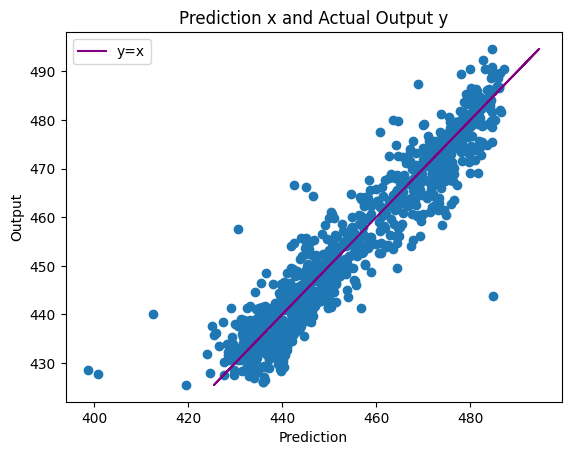

In [ ]:
plt.scatter(prediction_means, yTest) # Transform predictions back to original scale
plt.plot(yTest, yTest, color = 'purple', label = 'y=x')
plt.title('Prediction x and Actual Output y')
plt.xlabel('Prediction')
plt.ylabel('Output')
plt.legend()
plt.show()

# Compare different amount of points

In [ ]:
def severalInducingPoints(listOfPoints):
  timeList = []
  for points in listOfPoints:
    inducingPointsX = torch.tensor(xTrain_standardized[:points]) # Choose how many points to pick
    inducingPointsY = torch.tensor(yTrain[:points]) # Choose how many points to pick
    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
    model = GPModel(inducingPointsX, inducingPointsY, likelihood) # Send in inducing points as the training points
    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()
    start_time = time.time() # Start time
    train(model, inducingPointsX, inducingPointsY) # Train the model
    end_time = time.time() # End time
    execution_time = end_time - start_time # Calculate execution time
    timeList.append(execution_time) # Add mean time of all runs for current amount of points
    # Plot
    model.eval() # eval mode is for computing predictions through the model posterior.
    likelihood.eval()
  return timeList
timeList = severalInducingPoints([100,200,300,400,500,600,700,800,900,1000])


<ipython-input-17-f1102922dfc9>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inducingPointsX = torch.tensor(xTrain_standardized[:points]) # Choose how many points to pick
<ipython-input-17-f1102922dfc9>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inducingPointsY = torch.tensor(yTrain[:points]) # Choose how many points to pick


# Plot The Different Times

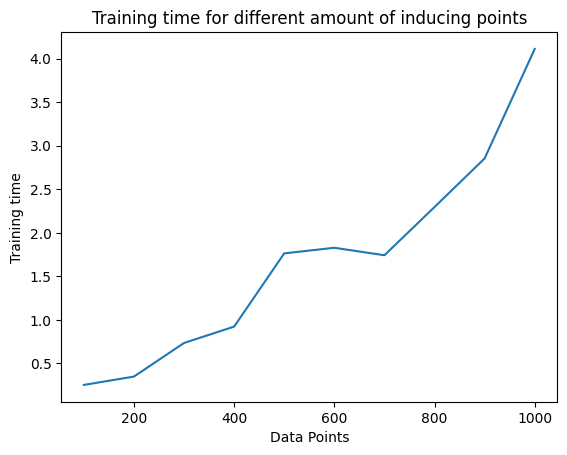

In [ ]:
plt.title('Training time for different amount of inducing points')
plt.xlabel('Data Points')
plt.ylabel('Training time')
plt.plot([100,200,300,400,500,600,700,800,900,1000],timeList)


# Inducing Points with K-means

#K-means

In [ ]:
# Changing n_init will drastically change execution time
def kmeansPoints(x, y, N): # The dataset (X,Y) and the N amount of inducing points wished
  RS = 0 # Random state
  kmeans = KMeans(n_clusters=N, n_init=1, random_state=RS ).fit(x) # Apply K-means clustering on the normalized training data
  xInducing = kmeans.cluster_centers_ # Use the centers of the clusters as the inducing points
  # To get the corresponding y values for each inducing point, compute the closest data point.
  closest_indices, _ = pairwise_distances_argmin_min(xInducing, x) # Will return indexes of xTrain_KMeans which is most similar(the same in this case) as xInducing
  yInducing = y[closest_indices] # Choose the corresponding y values for the inducing points
  return torch.from_numpy(xInducing).float(), yInducing

# Compare different amounts of inducing points
## Speed and Performance

In [ ]:
# Trains models one by one for each amount of inducing points, and plots each model with plots [rows,columns](must match the length of listOfPoints)
def severalInducingPointsKmeans(listOfPoints):
  RMSE_list = []
  K_means_times = []
  train_times = []
  posterior_times = []
  for points in listOfPoints:
    start_time = time.time() # Start time
    inducingPointsX, inducingPointsY = kmeansPoints(xTrain_standardized, yTrain, points) # Calculate Incucing Points
    end_time = time.time() # End time
    execution_time = end_time - start_time # Calcualte execution time
    K_means_times.append(execution_time) # Append time


    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
    model = GPModel(inducingPointsX, inducingPointsY, likelihood) # Send in inducing points as the training points
    if torch.cuda.is_available():
        model = model.cuda()
        model.likelihood = likelihood.cuda()
    start_time = time.time() # Start time
    train(model, inducingPointsX, inducingPointsY) # Train the model
    end_time = time.time() # End time
    execution_time = end_time - start_time # Calcualte execution time
    train_times.append(execution_time) # Append average time
    # Performance
    model.eval() # eval mode is for computing predictions through the model posterior.
    model.likelihood.eval()

    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
      start_time = time.time() # Start time
      observed_pred =  model.likelihood(model(xTest_standardized))# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value
      end_time = time.time() # End time
      execution_time = end_time - start_time # Calculate execution time
      posterior_times.append(execution_time) # Append average time
      mean = observed_pred.mean.numpy()


      squared_error = (mean - yTest.numpy())**2 # Compute the squared error
      mean_SE = squared_error.mean() # Compute the mean squared error
      root_MSE = math.sqrt(mean_SE) # Compute the square root of the mean squared error
      #RMSE = (root_MSE * yTest_std) + yTest_standardized_mean # Transform to original scale
      RMSE_list.append(root_MSE) # Append to list of RMSE to plot later

  return RMSE_list, K_means_times, train_times, posterior_times # Return all lists for plotting

# Plot Training Times and Performance for different set of Inducing Points

# Plot Function

In [ ]:
def bar_plot_func(x, K_means_times, train_times, posterior_times, RMSE_list, width):
  # PLOT

  indices = np.array(x)

  # Width of a bar
  width = width

  fig, axs = plt.subplots(2, 1, figsize=(15, 10))  # Create a figure and a 1x2 subplot

  # First subplot
  axs[0].bar(indices - width, K_means_times, width, label='K-means time', color = "black")
  axs[0].bar(indices, train_times, width, label='Train time', color = "purple")
  axs[0].bar(indices + width, posterior_times, width, label='Posterior time', color = "blue")

  # Adding labels
  axs[0].set_xlabel('Inducing Points')
  axs[0].set_ylabel('time in seconds')
  axs[0].set_title('Performance of different amount of Inducing Points for Power Dataset')

  # Adding legend
  axs[0].legend()

  # Second subplot
  axs[1].bar(indices, RMSE_list, width, label='RMSE', color = "purple")

  # Adding labels
  axs[1].set_xlabel('Inducing Points')
  axs[1].set_ylabel('RMSE')
  axs[1].set_title('RMSE of different amount of Inducing Points for Power Dataset')

  # Adding legend
  axs[1].legend()

  # Function to show the plot
  plt.show()

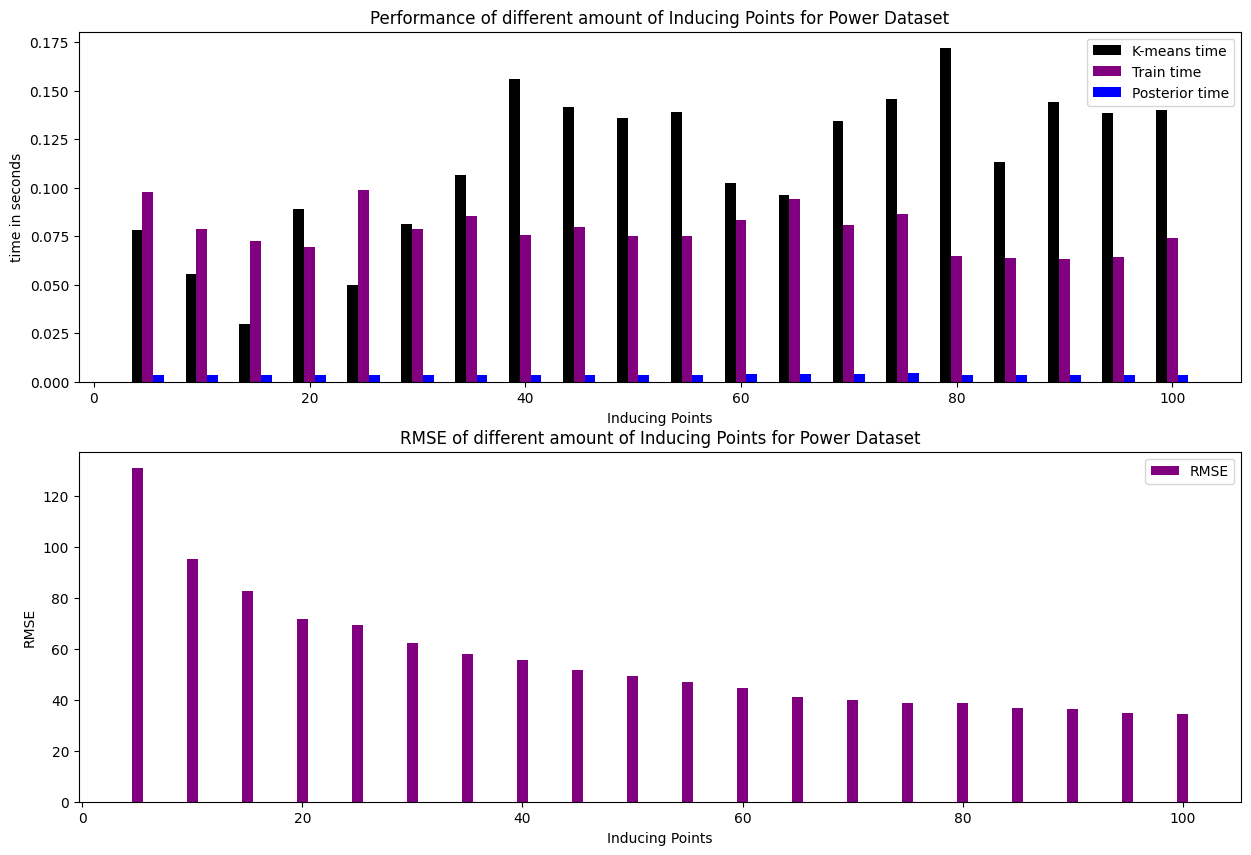

In [ ]:
# Get Values
input1 = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
RMSE_list1, K_means_times1, train_times1, posterior_times1 = severalInducingPointsKmeans(input1)
bar_plot_func(input1, K_means_times1, train_times1, posterior_times1, RMSE_list1, 1)

# Larger sets of Inducing Points

In [ ]:
# Get Values
input2 = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]
RMSE_list2, K_means_times2, train_times2, posterior_times2 = severalInducingPointsKmeans(input2)

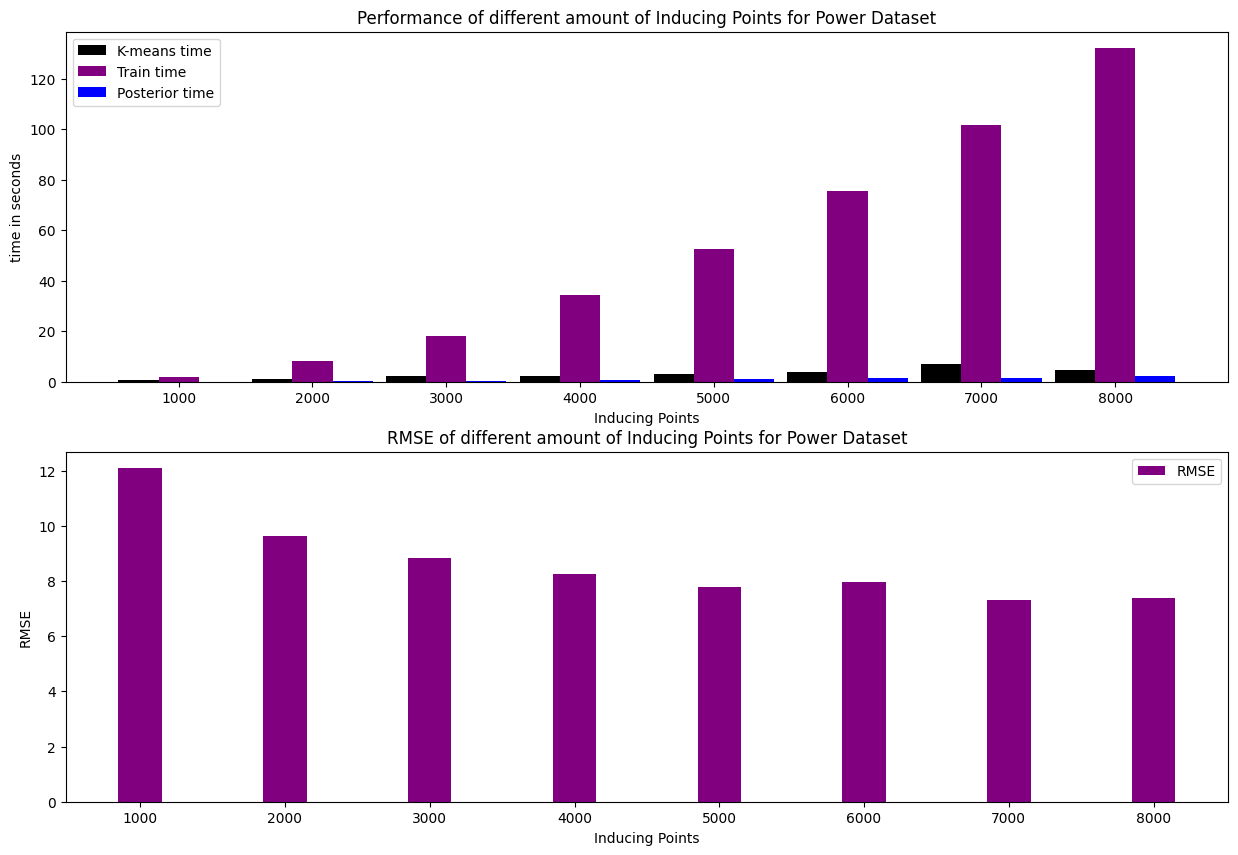

In [ ]:
bar_plot_func(input2, K_means_times2, train_times2, posterior_times2, RMSE_list2, 300)

# Another set of inducing points

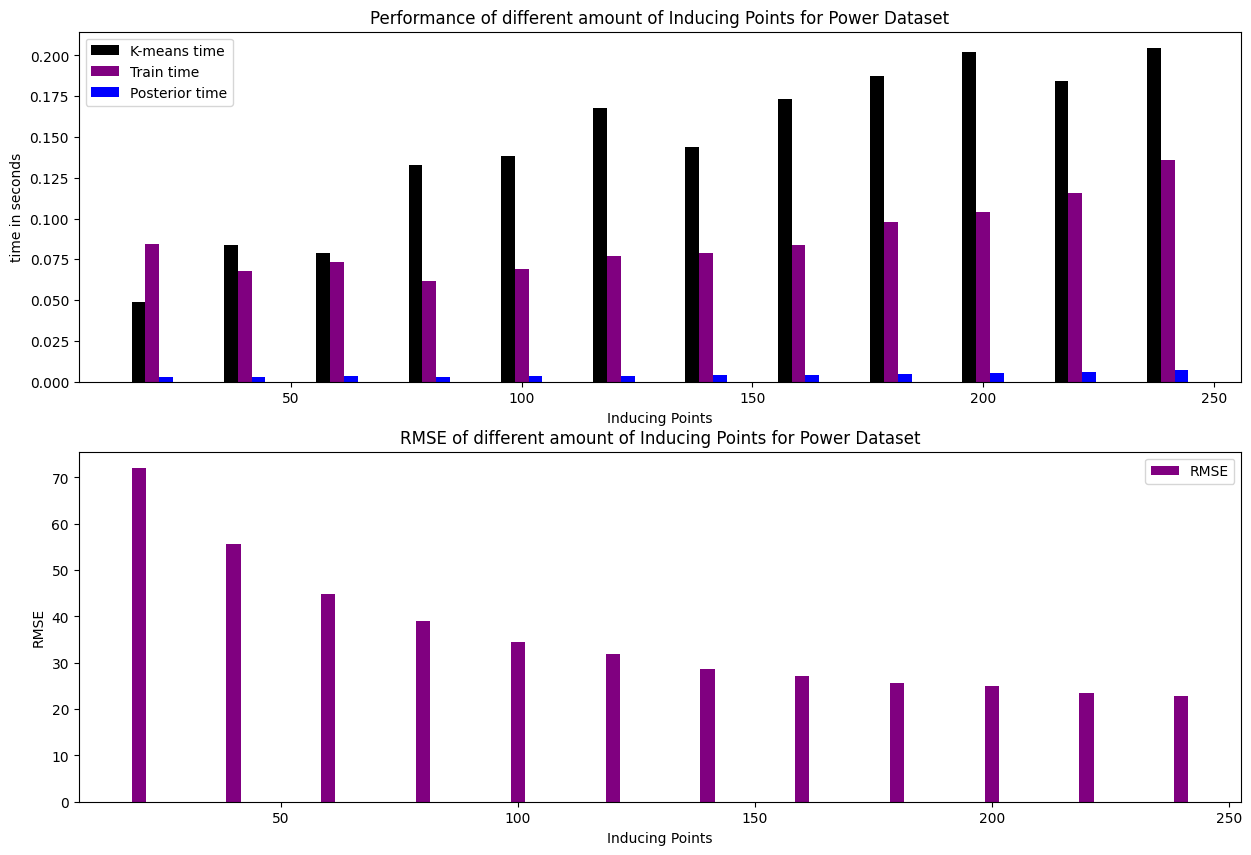

In [ ]:
# Get Values
input3 = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240]
RMSE_list3, K_means_times3, train_times3, posterior_times3 = severalInducingPointsKmeans(input3)
bar_plot_func(input3, K_means_times3, train_times3, posterior_times3, RMSE_list3, 3)

#Final Comparison

90% of training points

In [ ]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
model_final = GPModel(xTrain_standardized, yTrain, likelihood) # Use training points and given likelihood
if torch.cuda.is_available():
    model_final = model_final.cuda()
    model.likelihood = likelihood.cuda()


start_time = time.time() # Start time
train(model_final, xTrain_standardized, yTrain) # Train the full model
end_time = time.time() # End time
execution_time_final = end_time - start_time # Calcualte execution time

# EVALUATE full model
model_final.eval() # eval mode is for computing predictions through the model posterior.
model.likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
    observed_pred = model_final.likelihood(model_final(xTest_standardized))# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value
    prediction_means = observed_pred.mean.numpy()

    squared_error = (prediction_means -  yTest.numpy())**2 # Compute the squared error

    mean_SE = squared_error.mean() # Compute the mean squared error

    root_MSE = math.sqrt(mean_SE) # Compute the square root of the mean squared error

    # To transform the RMSE back to the original scale after normalization,
    # you can simply multiply the RMSE by the standard deviation of the original output data and add the mean
    #RMSE_final = ((root_MSE * yTest_std) + yTest_standardized_mean)
    RMSE_final = root_MSE

Total time from the inducing points with K-means

In [ ]:
sum_time_inducing = [] # Total time for the inducing points
for i in range(len(K_means_times3)):
  sum_time_inducing.append(K_means_times3[i] + train_times3[i] + posterior_times3[i])

Plot the speed and performance of the total model and the different models trained on inducing points

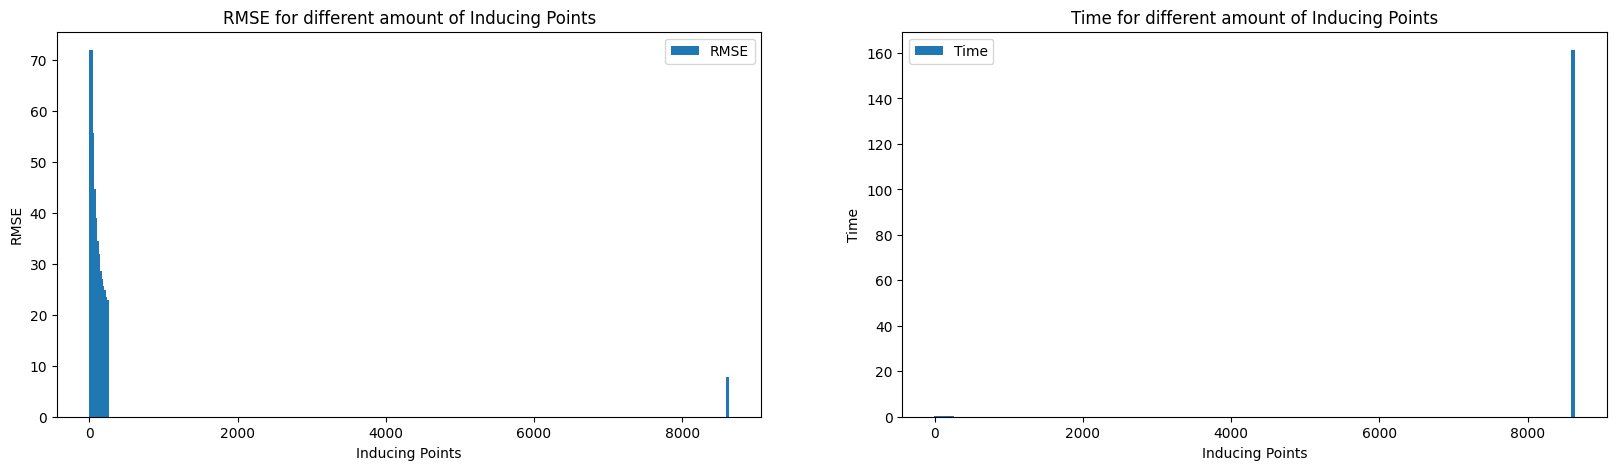

In [ ]:
RMSE = RMSE_list3+[RMSE_final] # List of RMSEs
times = sum_time_inducing+[execution_time_final] # list of training times

# PLOT
width = 50
indices_final = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240] # x values in bar plot

indices_final.append(8611) # 8611 is 90% of training points
fig, axs = plt.subplots(1, 2, figsize=(20, 5))  # Create a figure and a 1x2 subplot
# First subplot
axs[0].bar(indices_final, RMSE, label='RMSE', width = width)
axs[0].set_xlabel('Inducing Points')
axs[0].set_ylabel('RMSE')
axs[0].set_title('RMSE for different amount of Inducing Points')
axs[0].legend()

# Second subplot
axs[1].bar(indices_final, times, label='Time', width = width)
axs[1].set_xlabel('Inducing Points')
axs[1].set_ylabel('Time')
axs[1].set_title('Time for different amount of Inducing Points')
axs[1].legend()

# Show the plot
plt.show()

sample_data/
